In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Import required Libraries**

In [ ]:
! pip install -q tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 5.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.keras.compat import keras

# **Load data**

In [ ]:
batch_size = 64
img_height = 224
img_width = 224

data_dir = "/content/drive/MyDrive/New Folder/TinyML/Datasets/Tomatoes Diseases/"

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    data_dir + "Train",
    validation_split=0.2,
    subset="training",
    seed=377,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 12860 files belonging to 10 classes.
Using 10288 files for training.


In [ ]:
val_ds = keras.utils.image_dataset_from_directory(
    data_dir + "Train",
    validation_split=0.2,
    subset="validation",
    seed=377,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 12860 files belonging to 10 classes.
Using 2572 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mite_Two_spotted_sm',
 'Target_Spot',
 'Yellow_Leaf__Curl_Virus',
 'healthy',
 'mosaic_virus']

# **Visualize the data**

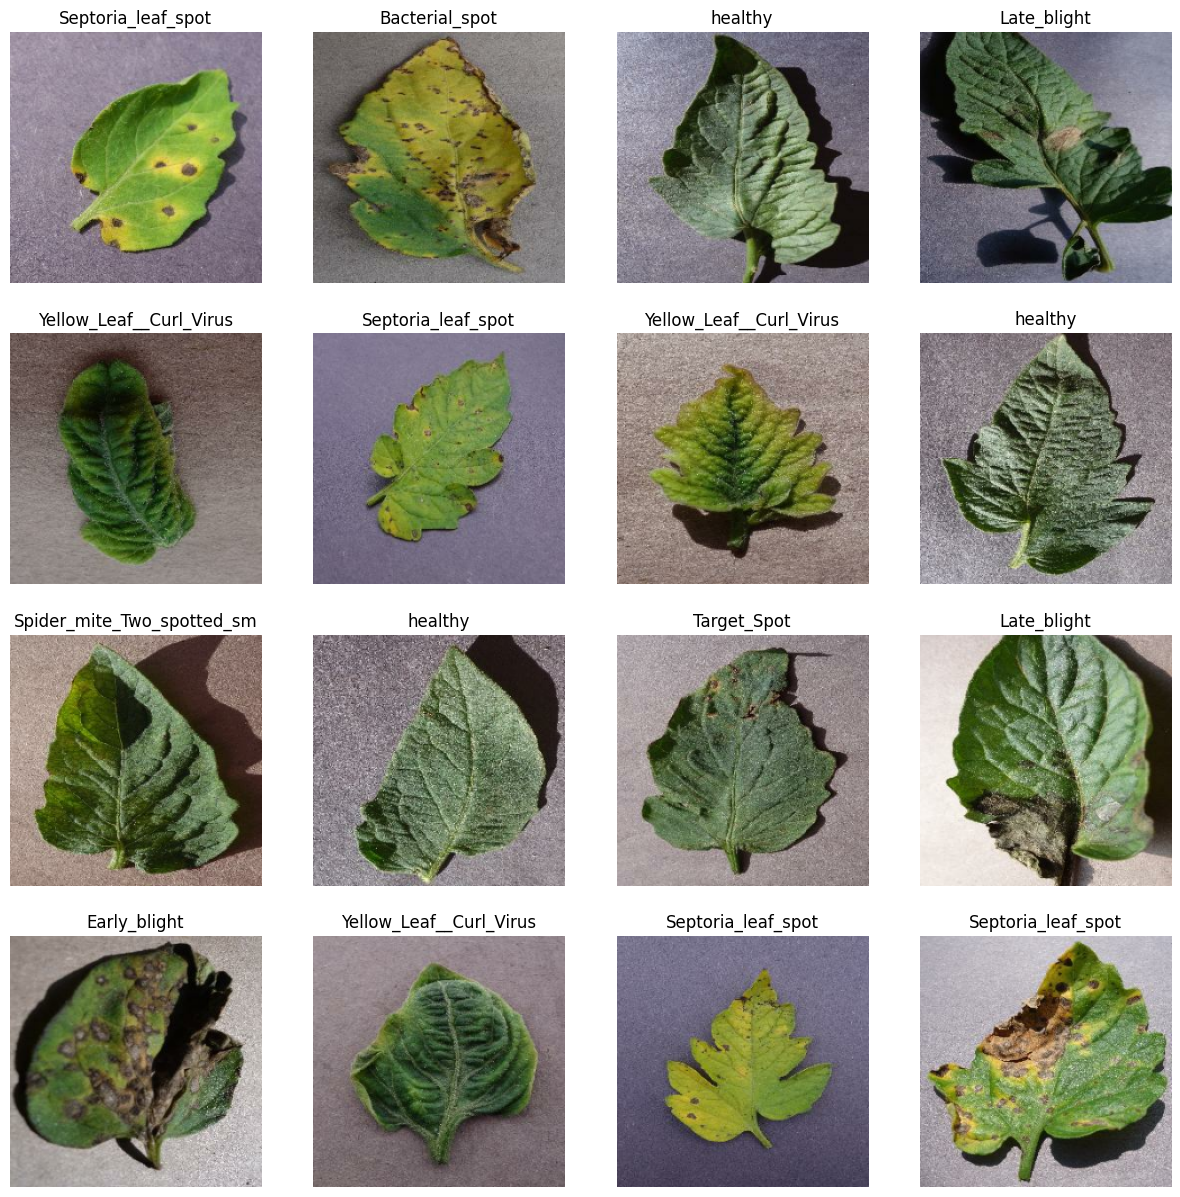

In [ ]:
plt.figure(figsize=(15, 15))
for img, lab in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[lab[i]])
    plt.axis("off")

# **Preprocess the data**

In [ ]:
# set 8000 images for training and 1024 images for validation
train_nds = train_ds.take(125)
val_nds = val_ds.take(16)

In [ ]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

train_nds = train_nds.cache().prefetch(buffer_size=AUTOTUNE)
val_nds = val_nds.cache().prefetch(buffer_size=AUTOTUNE)

# **Load Model**

In [ ]:
AlexNet = keras.models.load_model("/content/drive/MyDrive/New Folder/TinyML/SaveModels/AlexNet.h5")

In [ ]:
AlexNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_5 (Bat  (None, 54, 54, 96)        384       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 26, 26, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_6 (Bat  (None, 26, 26, 256)      

# **Pruning**

In [ ]:
num_images = 8000
end_step = np.ceil(num_images / batch_size).astype(np.int32) * 100


callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]

conv_pruning = {
    "pruning_schedule": tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.20,
        final_sparsity=0.90,
        begin_step=0,
        end_step=end_step,)
}


dense_pruning = {
    "pruning_schedule": tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.20,
        final_sparsity=0.90,
        begin_step=0,
        end_step=end_step,)
}


def pruning(layer):
  if isinstance(layer, keras.layers.Conv2D):
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **conv_pruning)
  if isinstance(layer, keras.layers.Dense):
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **dense_pruning)
  return layer

# **Compile and train the model**

In [ ]:
pruned_AlexNet = keras.models.clone_model(
    AlexNet,
    clone_function=pruning,
)

pruned_AlexNet.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=keras.optimizers.Adam(learning_rate=1e-5),
  metrics=['accuracy']
)

pruned_AlexNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 prune_low_magnitude_conv2d  (None, 54, 54, 96)        69794     
 _5 (PruneLowMagnitude)                                          
                                                                 
 batch_normalization_5 (Bat  (None, 54, 54, 96)        384       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 26, 26, 96)        0         
 g2D)                                                            
                                                                 
 prune_low_magnitude_conv2d  (None, 26, 26, 256)       1229058   
 _6 (PruneLowMagnitude)                               

In [ ]:
history = pruned_AlexNet.fit(
    train_nds,
    validation_data=val_nds,
    epochs=100,
    callbacks=callbacks,
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


125/125 [==============================] - 1523s 12s/step - loss: 0.2772 - accuracy: 0.9380 - val_loss: 0.8227 - val_accuracy: 0.8320
Epoch 2/100
125/125 [==============================] - 9s 74ms/step - loss: 0.2476 - accuracy: 0.9321 - val_loss: 0.1440 - val_accuracy: 0.9600
Epoch 3/100
125/125 [==============================] - 9s 73ms/step - loss: 0.1938 - accuracy: 0.9426 - val_loss: 0.1323 - val_accuracy: 0.9580
Epoch 4/100
125/125 [==============================] - 9s 74ms/step - loss: 0.1915 - accuracy: 0.9424 - val_loss: 0.3001 - val_accuracy: 0.9121
Epoch 5/100
125/125 [==============================] - 9s 75ms/step - loss: 0.1637 - accuracy: 0.9469 - val_loss: 0.1629 - val_accuracy: 0.9521
Epoch 6/100
125/125 [==============================] - 9s 75ms/step - loss: 0.1658 - accuracy: 0.9481 - val_loss: 0.1610 - val_accuracy: 0.9521
Epoch 7/100
125/125 [==============================] - 9s 75ms/step - loss: 0.1742 - accuracy: 0.9439 - val_loss: 0.1302 - val_accuracy: 0.9551
Ep

In [ ]:
def plot_curves(his):

    loss = his.history['loss']
    val_loss = his.history['val_loss']

    accuracy = his.history['accuracy']
    val_accuracy = his.history['val_accuracy']

    epochs = range(len(his.history['loss']))

    # ploting the loss
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure()

    # ploting the accuracy
    plt.plot(epochs, accuracy, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.figure()

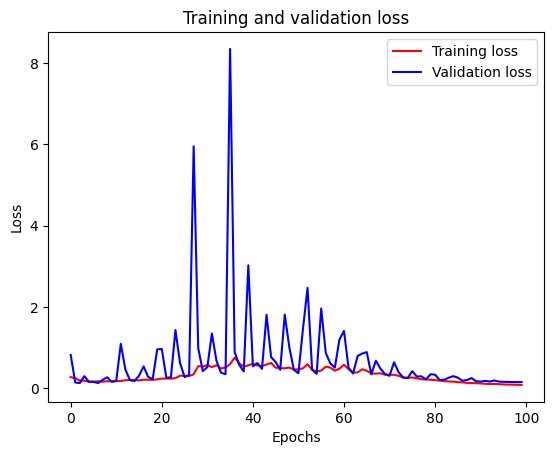

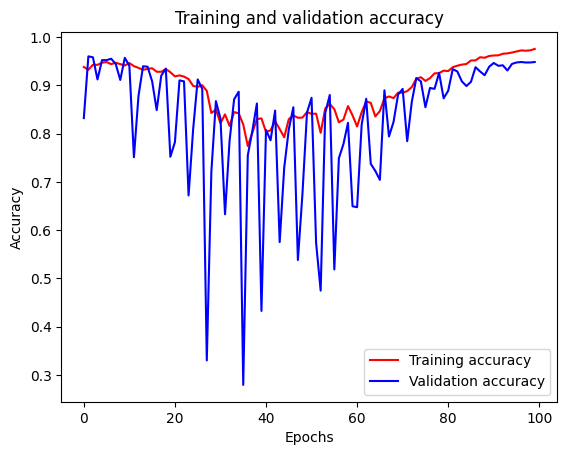

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_curves(history)

In [ ]:
def print_model_weights_sparsity(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

In [ ]:
pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_AlexNet)
print_model_weights_sparsity(pruned_model)

conv2d_5/kernel:0: 90.00% sparsity  (31363/34848)
conv2d_6/kernel:0: 90.00% sparsity  (552960/614400)
conv2d_7/kernel:0: 90.00% sparsity  (796262/884736)
conv2d_8/kernel:0: 90.00% sparsity  (1194394/1327104)
conv2d_9/kernel:0: 90.00% sparsity  (796262/884736)
dense_3/kernel:0: 90.00% sparsity  (23592960/26214400)
dense_4/kernel:0: 90.00% sparsity  (15099494/16777216)
dense_5/kernel:0: 90.00% sparsity  (36864/40960)


In [32]:
print_model_weights_sparsity(AlexNet)

conv2d_5/kernel:0: 90.00% sparsity  (31363/34848)
conv2d_6/kernel:0: 90.00% sparsity  (552960/614400)
conv2d_7/kernel:0: 90.00% sparsity  (796262/884736)
conv2d_8/kernel:0: 90.00% sparsity  (1194394/1327104)
conv2d_9/kernel:0: 90.00% sparsity  (796262/884736)
dense_3/kernel:0: 90.00% sparsity  (23592960/26214400)
dense_4/kernel:0: 90.00% sparsity  (15099494/16777216)
dense_5/kernel:0: 90.00% sparsity  (36864/40960)


In [24]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "Test",
    seed=633,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 3198 files belonging to 10 classes.


In [25]:
class_names = test_ds.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mite_Two_spotted_sm',
 'Target_Spot',
 'Yellow_Leaf__Curl_Virus',
 'healthy',
 'mosaic_virus']

In [26]:
test_ds = test_ds.take(16)

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

test_nds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
pruned_model.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=keras.optimizers.Adam(learning_rate=1e-5),
  metrics=['accuracy']
)

In [31]:
loss, acc = pruned_model.evaluate(test_nds)
print("Accuracy", acc)
print("Loss", loss)

/usr/local/lib/python3.10/dist-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 [==============================] - 286s 11s/step - loss: 0.1399 - accuracy: 0.9482
Accuracy 0.9482421875
Loss 0.13989871740341187


In [34]:
model = "drive/MyDrive/New Folder/TinyML/SaveModels/pruned_AlexNet.h5"
keras.models.save_model(pruned_model, model, include_optimizer=False)


<ipython-input-34-edc454db7dcc>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(pruned_model, model, include_optimizer=False)


In [35]:
# Get predictions
y_pred = AlexNet.predict(test_nds)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_nds], axis=0)

# Compute confusion matrix
cm = tf.math.confusion_matrix(y_true, y_pred)

16/16 [==============================] - 1s 28ms/step


In [36]:
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[142,   1,   0,   0,   0,   0,   0,   1,   0,   0],
       [  3,  32,   8,   1,   1,   1,   1,   2,   0,   1],
       [  1,   3, 118,   2,   2,   0,   0,   0,   0,   0],
       [  0,   0,   0,  52,   0,   1,   0,   0,   1,   0],
       [  0,   0,   0,   2,  96,   0,   2,   0,   1,   0],
       [  0,   0,   0,   2,   0, 108,   8,   0,   0,   2],
       [  0,   0,   0,   0,   1,   1,  79,   0,   0,   0],
       [  1,   0,   1,   0,   0,   1,   0, 217,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0, 107,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  20]], dtype=int32)>

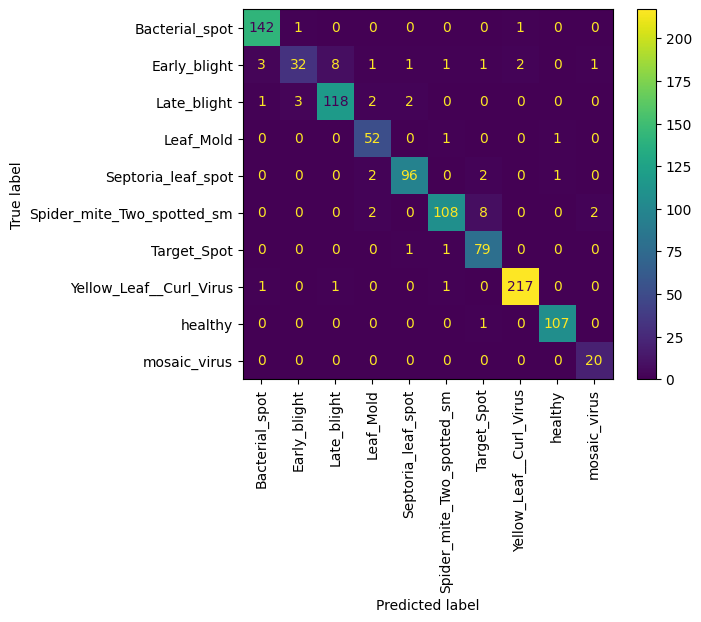

In [37]:
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=class_names, xticks_rotation='vertical'
)

In [38]:
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Accuracy", acc)
print("Loss", loss)

Precision: 0.9295362886237131
Recall: 0.9328490079166647
F1 Score: 0.9280925694334285
Accuracy 0.9482421875
Loss 0.13989871740341187
